# Pedestrian Dectection

### Data processing


In [5]:
!pip install tqdm

In [6]:
import os
import json
from glob import glob
from tqdm import tqdm

class_mapping = {
    "person-group-far-away": 0,
    "pedestrian":0,
}

# Paths
image_dir = "/kaggle/input/eurocitypersonsvalidation/ECP_day_img_val/ECP/day/img/val/"
labels_dir = "/kaggle/input/eurocitypersonsvalidation/ECP_day_labels_val/ECP/day/labels/val/"
output_dir = "/kaggle/working/eurocitypersonsvalidation/ECP_day_yolov8_labels_val/ECP/day/labels/val/"

# Ensure output directory exists
os.makedirs(output_dir, exist_ok=True)

# Define class mapping (modify if multiple classes exist)
class_map = {"pedestrian":0}

# Function to convert JSON to YOLO format
def convert_json(json_path):
    with open(json_path, "r") as f:
        data = json.load(f)
    
    image_width = data["imagewidth"]
    image_height = data["imageheight"]
    yolo_annotations = []
    
    for obj in data.get("children", []):
        class_name = obj["identity"]
        if class_name not in class_map:
            continue  # Ignore unknown classes
        
        class_id = class_map[class_name]
        x0, y0, x1, y1 = obj["x0"], obj["y0"], obj["x1"], obj["y1"]
        
        # Convert to YOLO format
        center_x = ((x0 + x1) / 2) / image_width
        center_y = ((y0 + y1) / 2) / image_height
        width = (x1 - x0) / image_width
        height = (y1 - y0) / image_height

        yolo_annotations.append(f"{class_id} {center_x:.6f} {center_y:.6f} {width:.6f} {height:.6f}")

    return yolo_annotations

# Process all JSON files
json_files = glob(os.path.join(labels_dir, "**/*.json"), recursive=True)

for json_file in tqdm(json_files):
    # Generate corresponding .txt filename
    txt_file = json_file.replace(labels_dir, output_dir).replace(".json", ".txt")
    os.makedirs(os.path.dirname(txt_file), exist_ok=True)

    # Convert and save
    yolo_data = convert_json(json_file)
    with open(txt_file, "w") as f:
        f.write("\n".join(yolo_data))

print("Conversion completed. YOLO annotations saved in:", output_dir)

100%|██████████| 4266/4266 [00:12<00:00, 333.25it/s]

Conversion completed. YOLO annotations saved in: /kaggle/working/eurocitypersonsvalidation/ECP_day_yolov8_labels_val/ECP/day/labels/val/


In [7]:
# yolo preprocessing
import os
import shutil
import random
from glob import glob
from tqdm import tqdm

def prepare_yolo_dataset(image_dir, label_dir, output_dir, train_ratio=0.7, val_ratio=0.1, test_ratio=0.2):
    """
    Organizes YOLO dataset into train/val/test splits.

    Args:
        image_dir (str): Path to the directory containing all images.
        label_dir (str): Path to the directory containing all labels.
        output_dir (str): Destination directory for the organized dataset.
        train_ratio (float): Fraction of dataset for training.
        val_ratio (float): Fraction of dataset for validation.
        test_ratio (float): Fraction of dataset for testing.
    """

    # Ensure ratios sum to 1
    assert train_ratio + val_ratio + test_ratio == 1, "Train, val, and test ratios must sum to 1."

    # Create output directories
    for split in ["train", "val", "test"]:
        os.makedirs(os.path.join(output_dir, "images", split), exist_ok=True)
        os.makedirs(os.path.join(output_dir, "labels", split), exist_ok=True)

    # Collect all image-label pairs
    image_paths = glob(os.path.join(image_dir, "**/*.png"), recursive=True)
    random.shuffle(image_paths)  # Shuffle dataset to mix cities

    paired_data = []
    for img_path in tqdm(image_paths):
        # Get corresponding label path
        label_path = img_path.replace(image_dir, label_dir).replace(".png", ".txt")
        if os.path.exists(label_path):  # Ensure label exists
            paired_data.append((img_path, label_path))

    # Compute dataset splits
    total_count = len(paired_data)
    train_count = int(total_count * train_ratio)
    val_count = int(total_count * val_ratio)

    train_set = paired_data[:train_count]
    val_set = paired_data[train_count:train_count + val_count]
    test_set = paired_data[train_count + val_count:]

    # Function to move files
    def move_files(data_split, split_name):
        for img_path, lbl_path in tqdm(data_split):
            shutil.copy(img_path, os.path.join(output_dir, "images", split_name, os.path.basename(img_path)))
            shutil.copy(lbl_path, os.path.join(output_dir, "labels", split_name, os.path.basename(lbl_path)))

    # Move images and labels to respective directories
    move_files(train_set, "train")
    move_files(val_set, "val")
    move_files(test_set, "test")

    # Create data.yaml
    yaml_content = f"""
    path: {output_dir}
    train: images/train
    val: images/val
    test: images/test
    
    nc: 1  # Number of classes
    names: ["pedestrian"]  # Modify class names if needed
    """
    with open(os.path.join(output_dir, "data.yaml"), "w") as f:
        f.write(yaml_content)

    print(f"Dataset prepared at {output_dir} with {train_count} train, {val_count} val, {total_count - train_count - val_count} test samples.")

# Example usage
image_dir = "/kaggle/input/eurocitypersonsvalidation/ECP_day_img_val/ECP/day/img/val"
label_dir = "/kaggle/working/eurocitypersonsvalidation/ECP_day_yolov8_labels_val/ECP/day/labels/val"
output_dir = "/kaggle/working/ecp_dataset"

prepare_yolo_dataset(image_dir, label_dir, output_dir)

# Changing global yaml 
# Create data.yaml
yaml_content = f"""
path: {output_dir}
train: images/train
val: images/val
test: images/test

nc: 1  # Number of classes
names: [0]  # Modify class names if needed
"""
with open(os.path.join(output_dir, "data.yaml"), "w") as f:
    f.write(yaml_content)

100%|██████████| 854/854 [00:28<00:00, 30.18it/s]

Dataset prepared at /kaggle/working/ecp_dataset with 2986 train, 426 val, 854 test samples.


In [4]:
!rm -rf /kaggle/working/eurocitypersonsvalidation

In [3]:
!pip install ultralytics -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 25.5 MB/s eta 0:00:0000:01


# YOLO

In [21]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
yolo_model = YOLO("yolov8l.pt") 

In [ ]:
import cv2
import matplotlib.pyplot as plt

def plot_yolo_bboxes(image_path, label_path, class_names=None):
    """
    Plots YOLO bounding boxes on an image.
    
    Args:
        image_path (str): Path to the image file.
        label_path (str): Path to the corresponding YOLO label (.txt) file.
        class_names (list, optional): List of class names (e.g., ["person", "car", ...]).
    """
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for proper display
    img_h, img_w, _ = image.shape

    # Read label file
    with open(label_path, "r") as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        center_x, center_y, width, height = map(float, parts[1:])

        # Convert YOLO format (normalized) to pixel coordinates
        x1 = int((center_x - width / 2) * img_w)
        y1 = int((center_y - height / 2) * img_h)
        x2 = int((center_x + width / 2) * img_w)
        y2 = int((center_y + height / 2) * img_h)

        # Draw bounding box
        color = (255, 0, 0)  # Red color for bounding boxes
        thickness = 2
        cv2.rectangle(image, (x1, y1), (x2, y2), color, thickness)

        # Draw class label
        label = class_names[class_id] if class_names else f"Class {class_id}"
        cv2.putText(image, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Display the image
    plt.figure(figsize=(10, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# Example usage
image_path = "/kaggle/input/eurocitypersonsvalidation/ECP_day_img_val/ECP/day/img/val/amsterdam/amsterdam_01081.png"
label_path = "/kaggle/working/eurocitypersonsvalidation/ECP_day_yolov8_labels_val/ECP/day/labels/val/amsterdam/amsterdam_01081.txt"
class_names = ["pedestrian"]  # Modify as needed

plot_yolo_bboxes(image_path, label_path, class_names)

In [ ]:
yolo_model.to("cuda")
yolo_model.train(data="/kaggle/working/ecp_dataset/data.yaml", 
                 epochs=50, 
                 imgsz=640, 
                 batch=16,
                 device="cuda",
                 project="/kaggle/working/yolo_training", name="first_real_run")

In [ ]:
yolo_model = YOLO("/kaggle/working/yolo_training/first_real_run/weights/best.pt")

In [ ]:
preds = yolo_model.predict("/kaggle/input/eurocitypersonsvalidation/ECP_day_img_val/ECP/day/img/val/amsterdam/amsterdam_01081.png")

In [ ]:
import numpy as np

# Load the image
image_path = "/kaggle/input/eurocitypersonsvalidation/ECP_day_img_val/ECP/day/img/val/amsterdam/amsterdam_01081.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct visualization

# Get prediction results
for result in preds:
    boxes = result.boxes  # Get detected bounding boxes
    for box in boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # Convert box coordinates to integers
        conf = float(box.conf[0])  # Confidence score
        class_id = int(box.cls[0])  # Class ID

        # Draw bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)

        # Put label (class + confidence)
        label = f"{yolo_model.names[class_id]}: {conf:.2f}"
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

# Show the image with bounding boxes
plt.figure(figsize=(10, 6))
plt.imshow(image)
plt.axis("off")
plt.show()

In [ ]:
import shutil

def zip_and_download_training_folder(training_dir="/kaggle/working/yolo_training/first_real_run", output_zip="/kaggle/working/yolo_training.zip"):
    """
    Compresses the training directory into a zip file and provides a link for downloading.
    
    :param training_dir: Path to the YOLO training directory.
    :param output_zip: Path where the zip file will be saved.
    """
    # Zip the training folder
    shutil.make_archive(output_zip.replace(".zip", ""), 'zip', training_dir)
    
    print(f"Training folder zipped successfully: {output_zip}")
    print("Download the zip file from: ")
    print(output_zip)

# Run the function
zip_and_download_training_folder()

In [ ]:
zip_and_download_training_folder(training_dir = "/kaggle/working/ecp_dataset", output_zip = "/kaggle/working/ecp_dataset.zip" )

In [ ]:
from IPython.display import FileLink

FileLink('/kaggle/working/ecp_dataset.zip')

In [ ]:
!tar -cvf - /kaggle/working/ecp_dataset | split -b 1000M - /kaggle/working/ecp_dataset.tar.part

# DETR

In [ ]:
from ultralytics import RTDETR

# Load a COCO-pretrained RT-DETR-l model
rtdetr_model = RTDETR("rtdetr-l.pt")

# Display model information (optional)
rtdetr_model.info()

In [ ]:
!mkdir -p /kaggle/working/ecp-yolov8/datasets
!cp -r /kaggle/input/ecp-yolov8/datasets/ecp_dataset /kaggle/working/ecp-yolov8/datasets/ecp_dataset

In [ ]:
output_dir = "/kaggle/working/ecp-yolov8/datasets/ecp_dataset"
yaml_content = f"""
path: {output_dir}
train: images/train
val: images/val
test: images/test

nc: 1  # Number of classes
names: [0]  # Modify class names if needed
"""
with open(os.path.join(output_dir, "data.yaml"), "w") as f:
    f.write(yaml_content)

In [ ]:
rtdetr_model.to("cpu")
rtdetr_model.train(data="/kaggle/working/ecp-yolov8/datasets/ecp_dataset/data.yaml", 
                 epochs=1, 
                 imgsz=640, 
                 batch=1,
                 device="cpu",
                 project="/kaggle/working/detr_training", name="real_run")

In [ ]:
rtdetr_model = RTDETR("/kaggle/working/detr_training/real_run/weights/best.pt")

In [ ]:
preds = rtdetr_model.predict("/kaggle/input/eurocitypersonsvalidation/ECP_day_img_val/ECP/day/img/val/amsterdam/amsterdam_01081.png")

In [ ]:
import numpy as np

# Load the image
image_path = "/kaggle/input/eurocitypersonsvalidation/ECP_day_img_val/ECP/day/img/val/amsterdam/amsterdam_01081.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct visualization

# Get prediction results
for result in preds:
    boxes = result.boxes  # Get detected bounding boxes
    for box in boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])  # Convert box coordinates to integers
        conf = float(box.conf[0])  # Confidence score
        class_id = int(box.cls[0])  # Class ID

        # Draw bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)

        # Put label (class + confidence)
        label = f"{rtdetr_model.names[class_id]}: {conf:.2f}"
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

# Show the image with bounding boxes
plt.figure(figsize=(10, 6))
plt.imshow(image)
plt.axis("off")
plt.show()

# Evaluation 

In [9]:
# Load the model
yolo = YOLO("/kaggle/input/yolov8_50/pytorch/default/1/best.pt")
rtdetr = RTDETR("/kaggle/path")

# Run the evaluation
yolo_results = yolo.val(data="/kaggle/working/ecp_dataset/data.yaml")
rtdetr_results = rtdetr.val(data="/kaggle/working/ecp_dataset/data.yaml")

# Print specific metrics
print("Average precision:", results.box.ap)
print("Average precision at IoU=0.50:", results.box.ap50)
print("Mean average precision:", results.box.map)
print("Mean average precision at IoU=0.50:", results.box.map50)
print("Mean average precision at IoU=0.75:", results.box.map75)
print("Mean average precision for different IoU thresholds:", results.box.maps)
print("Mean precision:", results.box.mp)
print("Precision:", results.box.p)
print("Recall:", results.box.r)

Ultralytics 8.3.86 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 112 layers, 43,607,379 parameters, 0 gradients, 164.8 GFLOPs


val: Scanning /kaggle/working/ecp_dataset/labels/val.cache... 426 images, 78 backgrounds, 0 corrupt: 100%|██████████| 426/426 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:13<00:00,  1.95it/s]


                   all        426       2202      0.799      0.656      0.731      0.466


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.8ms preprocess, 10.9ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/val3
Average precision for all classes: [[    0.73056     0.70722     0.67704     0.64186     0.58824     0.50643     0.38821     0.27115     0.12473    0.022728]]
Average precision: [    0.46582]
Average precision at IoU=0.50: [    0.73056]
Mean average precision: 0.4658189026225104
Mean average precision at IoU=0.50: 0.7305637522488869
Mean average precision at IoU=0.75: 0.5064320967762215
Mean average precision for different IoU thresholds: [    0.46582]
Mean precision: 0.7989950220898963


### Experiments with frozen backbone
https://docs.ultralytics.com/yolov5/tutorials/transfer_learning_with_frozen_layers/#before-you-start

# Robustness 

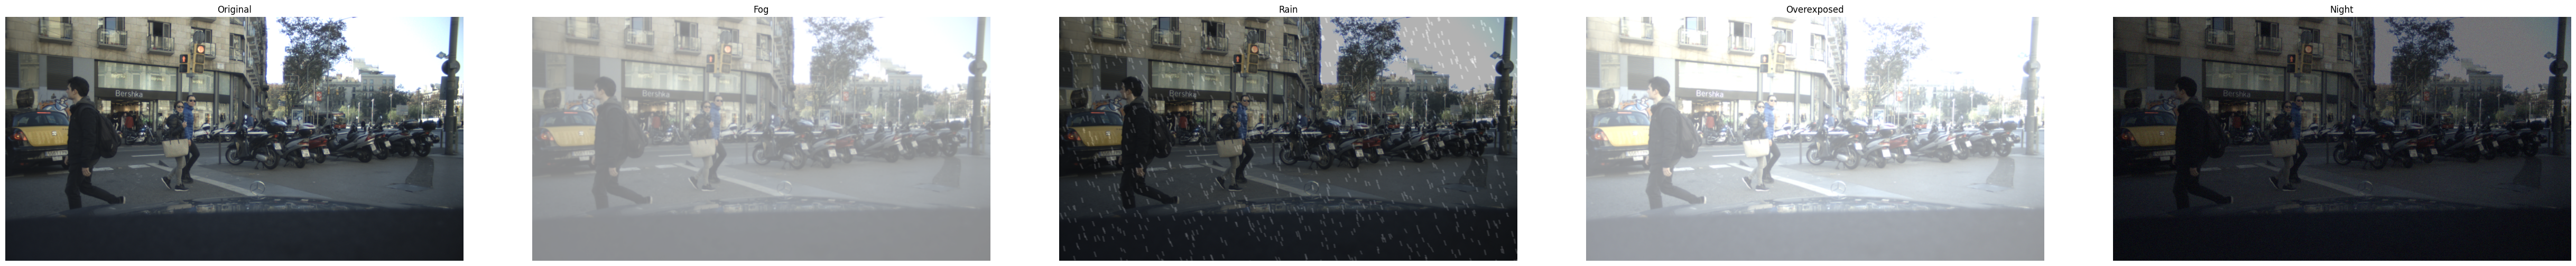

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define augmentation functions

def add_fog(image, fog_intensity=0.5):
    """
    Simulate fog by blending the original image with a white layer.
    
    Parameters:
      - image: Input image.
      - fog_intensity (float): 0.0 means no fog, 1.0 means heavy fog.
    
    Returns:
      - fogged_image: The image with simulated fog.
    """
    fog_layer = np.full_like(image, 255)
    fogged_image = cv2.addWeighted(image, 1 - fog_intensity, fog_layer, fog_intensity, 0)
    fogged_image = cv2.GaussianBlur(fogged_image, (7, 7), 0)
    return fogged_image

def add_rain(image, rain_intensity=0.5):
    """
    Simulate visible rain by drawing longer, thicker streaks with a nearly uniform downward angle.
    
    Parameters:
      - image: Input image.
      - rain_intensity (float): Controls the number and density of rain streaks.
    
    Returns:
      - rainy_image: Image with enhanced rain simulation.
    """
    rain_layer = np.zeros_like(image)
    h, w, _ = image.shape
    num_streaks = int(2000 * rain_intensity)
    
    for i in range(num_streaks):
        x = np.random.randint(0, w)
        y = np.random.randint(0, h)
        length = np.random.randint(15, 25)
        thickness = 2
        angle = np.random.uniform(0.2, 0.5)  # radians (~11° to ~29°)
        end_x = int(x + length * np.sin(angle))
        end_y = int(y + length * np.cos(angle))
        cv2.line(rain_layer, (x, y), (end_x, end_y), (255, 255, 255), thickness)
    
    # Apply a motion blur kernel to simulate falling rain
    kernel_size = 7
    kernel = np.zeros((kernel_size, kernel_size))
    kernel[int((kernel_size-1)/2), :] = np.ones(kernel_size)
    kernel = kernel / kernel_size
    rain_layer = cv2.filter2D(rain_layer, -1, kernel)
    
    rainy_image = cv2.addWeighted(image, 0.7, rain_layer, 0.3, 0)
    return rainy_image

def simulate_overexposure(image, exposure_intensity=0.5):
    """
    Simulate overexposure by increasing the brightness of the image.
    
    Parameters:
      - image: Input image.
      - exposure_intensity (float): 0.0 means no change, 1.0 means very high overexposure.
    
    Returns:
      - overexposed: The image with simulated overexposure.
    """
    overexposed = cv2.addWeighted(image, 1, np.full_like(image, 255), exposure_intensity, 0)
    overexposed = cv2.GaussianBlur(overexposed, (5, 5), 0)
    return overexposed

def simulate_night(image, night_intensity=0.5):
    """
    Simulate a night-time scene by reducing brightness, adding a slight blue tint,
    and incorporating Gaussian noise to mimic sensor noise in low-light conditions.
    
    Parameters:
      - image: Input image.
      - night_intensity (float): Determines how dark the image becomes (0.0 no effect, 1.0 very dark).
    
    Returns:
      - night_image: The image transformed to simulate a night-time scene.
    """
    # Convert to HSV and reduce the brightness (value channel)
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)
    v = np.clip(v * (1 - night_intensity), 0, 255).astype(np.uint8)
    hsv_night = cv2.merge([h, s, v])
    night_image = cv2.cvtColor(hsv_night, cv2.COLOR_HSV2RGB)
    
    # Add a slight blue tint to simulate cool night lighting
    blue_tint = np.full_like(night_image, (0, 0, 30))
    night_image = cv2.addWeighted(night_image, 0.9, blue_tint, 0.1, 0)
    
    # Add Gaussian noise in float, then clip to avoid pixelation artifacts
    noise = np.random.normal(0, 10, night_image.shape)
    night_image = np.clip(night_image.astype(np.float32) + noise, 0, 255).astype(np.uint8)
    
    return night_image

# Read the image from the provided Kaggle path
img_path = "/kaggle/input/eurocitypersonsvalidation/ECP_day_img_val/ECP/day/img/val/barcelona/barcelona_01263.png"
image = cv2.imread(img_path)
if image is None:
    raise ValueError("Image not found at the specified path!")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Apply augmentations
fog_image = add_fog(image, fog_intensity=0.5)
rain_image = add_rain(image, rain_intensity=0.5)
overexposed_image = simulate_overexposure(image, exposure_intensity=0.5)
night_image = simulate_night(image, night_intensity=0.5)

# Display all images in a grid
titles = ["Original", "Fog", "Rain", "Overexposed", "Night"]
images = [image, fog_image, rain_image, overexposed_image, night_image]

plt.figure(figsize=(50, 5))
for i, (title, img) in enumerate(zip(titles, images)):
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
plt.tight_layout()
plt.savefig("augmented_images.png", dpi=300)
plt.show()


## Evaluate 

In [2]:
import os
import random
import glob
import cv2
import yaml
import shutil

# -------------------------------------------------------------------
# 1. Balanced Sampling from City Folders
# -------------------------------------------------------------------

random.seed(42)

# Path to city subfolders containing .png/.jpg images
src_dir = "/kaggle/input/eurocitypersonsvalidation/ECP_day_img_val/ECP/day/img/val"
# Label files are here (train/val/test)
label_base = "/kaggle/input/ecp-yolov8/datasets/ecp_dataset/labels"

# List all city subdirectories
city_dirs = [d for d in os.listdir(src_dir) if os.path.isdir(os.path.join(src_dir, d))]
n_cities = len(city_dirs)

# We want a total of 100 images balanced across cities
images_per_city = 100 // n_cities
remainder = 100 % n_cities

sampled_images = []  # will hold (image_path, city)

# Sample images_per_city from each city
for city in city_dirs:
    city_path = os.path.join(src_dir, city)
    city_images = glob.glob(os.path.join(city_path, "*.png")) + glob.glob(os.path.join(city_path, "*.jpg"))
    
    if len(city_images) <= images_per_city:
        chosen = city_images
    else:
        chosen = random.sample(city_images, images_per_city)
    
    sampled_images.extend([(img, city) for img in chosen])

# If there's a remainder, sample extra from all remaining
if remainder > 0:
    all_remaining = []
    for city in city_dirs:
        city_path = os.path.join(src_dir, city)
        city_images = glob.glob(os.path.join(city_path, "*.png")) + glob.glob(os.path.join(city_path, "*.jpg"))
        # exclude already sampled
        sampled_in_city = [x[0] for x in sampled_images if x[1] == city]
        city_remaining = list(set(city_images) - set(sampled_in_city))
        all_remaining.extend([(img, city) for img in city_remaining])
    
    if len(all_remaining) >= remainder:
        extra = random.sample(all_remaining, remainder)
        sampled_images.extend(extra)

print("Total sampled images:", len(sampled_images))  # Expect 100

# -------------------------------------------------------------------
# 2. Define Augmentations
# -------------------------------------------------------------------
# Assuming you have these functions defined elsewhere:
# add_fog(image_rgb, fog_intensity=0.5)
# add_rain(image_rgb, rain_intensity=0.5)
# simulate_overexposure(image_rgb, exposure_intensity=0.5)
# simulate_night(image_rgb, night_intensity=0.5)

augmentations = {
    "fog":       lambda img: add_fog(img, fog_intensity=0.5),
    "rain":      lambda img: add_rain(img, rain_intensity=0.5),
    "overexposed": lambda img: simulate_overexposure(img, exposure_intensity=0.5),
    "night":     lambda img: simulate_night(img, night_intensity=0.5)
}

# -------------------------------------------------------------------
# 3. Helper Functions
# -------------------------------------------------------------------

def ensure_yolo_structure(base_dir, aug_name):
    """
    Creates YOLOv8 structure under:
      base_dir/aug_name/
        data_<aug_name>.yaml
        images/{train,val,test}
        labels/{train,val,test}
    Returns paths to 'images/test' and 'labels/test'.
    """
    aug_dir = os.path.join(base_dir, aug_name)
    # images subfolders
    os.makedirs(os.path.join(aug_dir, "images/train"), exist_ok=True)
    os.makedirs(os.path.join(aug_dir, "images/val"), exist_ok=True)
    os.makedirs(os.path.join(aug_dir, "images/test"), exist_ok=True)
    # labels subfolders
    os.makedirs(os.path.join(aug_dir, "labels/train"), exist_ok=True)
    os.makedirs(os.path.join(aug_dir, "labels/val"), exist_ok=True)
    os.makedirs(os.path.join(aug_dir, "labels/test"), exist_ok=True)
    return aug_dir

def create_data_yaml(aug_dir, aug_name, nc=1, names=[0]):
    """
    Creates data_<aug_name>.yaml referencing images/{train,val,test} and labels/{train,val,test}.
    """
    data_dict = {
        "train":  os.path.join("images", "train"),
        "val":    os.path.join("images", "val"),
        "test":   os.path.join("images", "test"),
        "nc":     nc,
        "names":  names
    }
    yaml_path = os.path.join(aug_dir, f"data_{aug_name}.yaml")
    with open(yaml_path, "w") as f:
        yaml.dump(data_dict, f)

def copy_label_if_exists(img_filename, dest_label_dir):
    """
    Given an image filename (e.g., 'barcelona_01261.png'),
    looks for a matching label file with .txt extension in
    label_base/{train,val,test}. If found, copy to dest_label_dir.
    """
    base_name = os.path.splitext(img_filename)[0]  # e.g. "barcelona_01261"
    label_file = base_name + ".txt"
    
    for split in ["train", "val", "test"]:
        candidate = os.path.join(label_base, split, label_file)
        if os.path.isfile(candidate):
            shutil.copy(candidate, os.path.join(dest_label_dir, label_file))
            return  # Found and copied, no need to search further

def save_augmented_image(rgb_img, save_path):
    """Convert from RGB to BGR and save with OpenCV."""
    bgr_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(save_path, bgr_img)

# -------------------------------------------------------------------
# 4. Create a Dataset for Each Augmentation
# -------------------------------------------------------------------

# Base directory for all new datasets
datasets_base = "/kaggle/working/ecp_dataset"

# We'll also create an "original" set for reference
all_aug_names = ["original"] + list(augmentations.keys())

for aug_name in all_aug_names:
    print(f"\nCreating dataset for augmentation: {aug_name}")

    # Create YOLO structure
    aug_dir = ensure_yolo_structure(datasets_base, aug_name)
    test_images_dir = os.path.join(aug_dir, "images", "val")
    test_labels_dir = os.path.join(aug_dir, "labels", "val")

    # Create data_<aug_name>.yaml
    create_data_yaml(aug_dir, aug_name, nc=1, names=[0])

    # For each sampled image, apply the augmentation (if not "original") and save
    for img_path, city in sampled_images:
        # Read original image (BGR)
        img_bgr = cv2.imread(img_path)
        if img_bgr is None:
            continue
        filename = os.path.basename(img_path)
        
        # If "original", just save the BGR image as-is
        if aug_name == "original":
            cv2.imwrite(os.path.join(test_images_dir, filename), img_bgr)
        else:
            # Convert to RGB
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            # Apply augmentation
            aug_rgb = augmentations[aug_name](img_rgb)
            # Save result
            save_augmented_image(aug_rgb, os.path.join(test_images_dir, filename))
        
        # Copy matching label if it exists
        copy_label_if_exists(filename, test_labels_dir)

    print(f"Dataset for '{aug_name}' created at: {aug_dir}")
    print(f" - Images: {os.path.join(aug_dir, 'images', 'test')}")
    print(f" - Labels: {os.path.join(aug_dir, 'labels', 'test')}")
    print(f" - YAML:   {os.path.join(aug_dir, f'data_{aug_name}.yaml')}")

print("\nAll augmented datasets created successfully!")


Total sampled images: 100

Creating dataset for augmentation: original
Dataset for 'original' created at: /kaggle/working/ecp_dataset/original
 - Images: /kaggle/working/ecp_dataset/original/images/test
 - Labels: /kaggle/working/ecp_dataset/original/labels/test
 - YAML:   /kaggle/working/ecp_dataset/original/data_original.yaml

Creating dataset for augmentation: fog
Dataset for 'fog' created at: /kaggle/working/ecp_dataset/fog
 - Images: /kaggle/working/ecp_dataset/fog/images/test
 - Labels: /kaggle/working/ecp_dataset/fog/labels/test
 - YAML:   /kaggle/working/ecp_dataset/fog/data_fog.yaml

Creating dataset for augmentation: rain
Dataset for 'rain' created at: /kaggle/working/ecp_dataset/rain
 - Images: /kaggle/working/ecp_dataset/rain/images/test
 - Labels: /kaggle/working/ecp_dataset/rain/labels/test
 - YAML:   /kaggle/working/ecp_dataset/rain/data_rain.yaml

Creating dataset for augmentation: overexposed
Dataset for 'overexposed' created at: /kaggle/working/ecp_dataset/overexposed

In [ ]:

data_config = {
    "train": "/kaggle/working/ecp_dataset/images/test/fog",  # empty placeholder
    "val":   "images/test",    # empty placeholder
    "test":  "images/test",   # test images (with subsets)
    "nc":    1,               # number of classes
    "names": [0]              # modify if you have class names
}

yaml_path = os.path.join(ecp_dataset_dir, "data.yaml")
with open(yaml_path, "w") as f:
    yaml.dump(data_config, f)

In [3]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 14.7 MB/s eta 0:00:00a 0:00:01


In [4]:
# Load the models
import ultralytics
from ultralytics import YOLO
from ultralytics import RTDETR

yolo = YOLO("/kaggle/input/yolov8_50/pytorch/default/1/best.pt")
rtdetr = RTDETR("/kaggle/input/detr/pytorch/default/1/detr_training/fine_tune_35/weights/last.pt")

# Define test subsets for evaluation.
# We have generated 5 test subsets from 100 images each:
# - Original (no augmentation)
# - Fog (simulated fog)
# - Rain (simulated rain)
# - Overexposed (simulated overexposure)
# - Night (simulated night-time conditions)
test_subsets = {
    "Original": "/kaggle/working/ecp_dataset/original/data_original.yaml",
    "Fog": "/kaggle/working/ecp_dataset/fog/data_fog.yaml",
    "Rain": "/kaggle/working/ecp_dataset/rain/data_rain.yaml",
    "Overexposed": "/kaggle/working/ecp_dataset/overexposed/data_overexposed.yaml",
    "Night": "/kaggle/working/ecp_dataset/night/data_night.yaml"
}

# Evaluate YOLO model on each test subset
print("===== YOLO Model Evaluation =====")
for subset, data_yaml in test_subsets.items():
    print(f"\nSubset: {subset}")
    yolo_results = yolo.val(data=data_yaml)
    print("Average precision:", yolo_results.box.ap)
    print("Average precision at IoU=0.50:", yolo_results.box.ap50)
    print("Mean average precision (mAP):", yolo_results.box.map)
    print("mAP at IoU=0.50:", yolo_results.box.map50)
    print("mAP at IoU=0.75:", yolo_results.box.map75)
    print("mAP for different IoU thresholds:", yolo_results.box.maps)
    print("Mean precision:", yolo_results.box.mp)
    print("Precision:", yolo_results.box.p)
    print("Recall:", yolo_results.box.r)

# Evaluate RTDETR model on each test subset
print("\n===== RTDETR Model Evaluation =====")
for subset, data_yaml in test_subsets.items():
    print(f"\nSubset: {subset}")
    rtdetr_results = rtdetr.val(data=data_yaml)
    print("Average precision:", rtdetr_results.box.ap)
    print("Average precision at IoU=0.50:", rtdetr_results.box.ap50)
    print("Mean average precision (mAP):", rtdetr_results.box.map)
    print("mAP at IoU=0.50:", rtdetr_results.box.map50)
    print("mAP at IoU=0.75:", rtdetr_results.box.map75)
    print("mAP for different IoU thresholds:", rtdetr_results.box.maps)
    print("Mean precision:", rtdetr_results.box.mp)
    print("Precision:", rtdetr_results.box.p)
    print("Recall:", rtdetr_results.box.r)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
===== YOLO Model Evaluation =====

Subset: Original
Ultralytics 8.3.96 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 112 layers, 43,607,379 parameters, 0 gradients, 164.8 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 18.1MB/s]
val: Scanning /kaggle/working/ecp_dataset/original/labels/val... 100 images, 18 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:01<00:00, 54.30it/s]

val: New cache created: /kaggle/working/ecp_dataset/original/labels/val.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [01:59<00:00, 17.08s/it]


                   all        100        543      0.823      0.632      0.735      0.455


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 2.4ms preprocess, 1134.1ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/val
Average precision: [    0.45475]
Average precision at IoU=0.50: [    0.73532]
Mean average precision (mAP): 0.4547456286868699
mAP at IoU=0.50: 0.7353197890208452
mAP at IoU=0.75: 0.4897484992852008
mAP for different IoU thresholds: [    0.45475]
Mean precision: 0.823100011038139
Precision: [     0.8231]
Recall: [    0.63168]

Subset: Fog
Ultralytics 8.3.96 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)


val: Scanning /kaggle/working/ecp_dataset/fog/labels/val... 100 images, 18 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:01<00:00, 91.67it/s]


val: New cache created: /kaggle/working/ecp_dataset/fog/labels/val.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [02:13<00:00, 19.04s/it]


                   all        100        543      0.818      0.603      0.692      0.421


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 2.2ms preprocess, 1268.8ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val2
Average precision: [    0.42105]
Average precision at IoU=0.50: [    0.69199]
Mean average precision (mAP): 0.4210477337357673
mAP at IoU=0.50: 0.6919918371129159
mAP at IoU=0.75: 0.4515934017670135
mAP for different IoU thresholds: [    0.42105]
Mean precision: 0.8178020411673786
Precision: [     0.8178]
Recall: [    0.60343]

Subset: Rain
Ultralytics 8.3.96 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)


val: Scanning /kaggle/working/ecp_dataset/rain/labels/val... 100 images, 18 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:01<00:00, 54.46it/s]

val: New cache created: /kaggle/working/ecp_dataset/rain/labels/val.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [01:54<00:00, 16.29s/it]


                   all        100        543      0.714       0.53      0.597      0.319


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 2.7ms preprocess, 1078.9ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs/detect/val3
Average precision: [    0.31931]
Average precision at IoU=0.50: [    0.59712]
Mean average precision (mAP): 0.319312986493851
mAP at IoU=0.50: 0.59711632249149
mAP at IoU=0.75: 0.31025426049755467
mAP for different IoU thresholds: [    0.31931]
Mean precision: 0.7137676443657568
Precision: [    0.71377]
Recall: [    0.53039]

Subset: Overexposed
Ultralytics 8.3.96 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)


val: Scanning /kaggle/working/ecp_dataset/overexposed/labels/val... 100 images, 18 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:01<00:00, 80.30it/s]

val: New cache created: /kaggle/working/ecp_dataset/overexposed/labels/val.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [01:52<00:00, 16.05s/it]


                   all        100        543      0.777      0.632      0.715      0.437


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 2.7ms preprocess, 1066.3ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/val4
Average precision: [    0.43717]
Average precision at IoU=0.50: [      0.715]
Mean average precision (mAP): 0.4371671340526054
mAP at IoU=0.50: 0.7150036057988717
mAP at IoU=0.75: 0.46876823484194663
mAP for different IoU thresholds: [    0.43717]
Mean precision: 0.776940136663404
Precision: [    0.77694]
Recall: [    0.63168]

Subset: Night
Ultralytics 8.3.96 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)


val: Scanning /kaggle/working/ecp_dataset/night/labels/val... 100 images, 18 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:02<00:00, 33.70it/s]


val: New cache created: /kaggle/working/ecp_dataset/night/labels/val.cache


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [01:53<00:00, 16.16s/it]


                   all        100        543       0.65      0.403      0.463      0.242


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 2.7ms preprocess, 1069.6ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/detect/val5
Average precision: [    0.24152]
Average precision at IoU=0.50: [    0.46277]
Mean average precision (mAP): 0.24152357854785303
mAP at IoU=0.50: 0.4627747446553518
mAP at IoU=0.75: 0.21443063454799588
mAP for different IoU thresholds: [    0.24152]
Mean precision: 0.649730096294962
Precision: [    0.64973]
Recall: [     0.4031]

===== RTDETR Model Evaluation =====

Subset: Original
Ultralytics 8.3.96 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
rt-detr-l summary: 302 layers, 31,985,795 parameters, 0 gradients, 103.4 GFLOPs


val: Scanning /kaggle/working/ecp_dataset/original/labels/val.cache... 100 images, 18 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [02:40<00:00, 22.86s/it]


                   all        100        543      0.839      0.663      0.795      0.489


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 1.0ms preprocess, 1539.8ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/val6
Average precision: [    0.48907]
Average precision at IoU=0.50: [    0.79526]
Mean average precision (mAP): 0.4890690496563832
mAP at IoU=0.50: 0.7952577719506764
mAP at IoU=0.75: 0.5095397907743331
mAP for different IoU thresholds: [    0.48907]
Mean precision: 0.839395578410963
Precision: [     0.8394]
Recall: [    0.66298]

Subset: Fog
Ultralytics 8.3.96 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
rt-detr-l summary: 302 layers, 31,985,795 parameters, 0 gradients, 103.4 GFLOPs


val: Scanning /kaggle/working/ecp_dataset/fog/labels/val.cache... 100 images, 18 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [03:07<00:00, 26.77s/it]


                   all        100        543      0.816      0.586      0.711      0.407


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 3.3ms preprocess, 1805.5ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/val7
Average precision: [    0.40743]
Average precision at IoU=0.50: [    0.71085]
Mean average precision (mAP): 0.40742642840971915
mAP at IoU=0.50: 0.7108516255487037
mAP at IoU=0.75: 0.4178583528393412
mAP for different IoU thresholds: [    0.40743]
Mean precision: 0.8159156441742872
Precision: [    0.81592]
Recall: [    0.58564]

Subset: Rain
Ultralytics 8.3.96 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
rt-detr-l summary: 302 layers, 31,985,795 parameters, 0 gradients, 103.4 GFLOPs


val: Scanning /kaggle/working/ecp_dataset/rain/labels/val.cache... 100 images, 18 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [02:37<00:00, 22.55s/it]


                   all        100        543      0.792      0.616      0.721      0.393


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 2.4ms preprocess, 1518.1ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val8
Average precision: [    0.39293]
Average precision at IoU=0.50: [    0.72104]
Mean average precision (mAP): 0.392930267016025
mAP at IoU=0.50: 0.7210391381916634
mAP at IoU=0.75: 0.37776514805439043
mAP for different IoU thresholds: [    0.39293]
Mean precision: 0.7917692120983838
Precision: [    0.79177]
Recall: [    0.61622]

Subset: Overexposed
Ultralytics 8.3.96 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
rt-detr-l summary: 302 layers, 31,985,795 parameters, 0 gradients, 103.4 GFLOPs


val: Scanning /kaggle/working/ecp_dataset/overexposed/labels/val.cache... 100 images, 18 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [02:42<00:00, 23.14s/it]


                   all        100        543      0.797      0.621      0.731      0.433


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 1.0ms preprocess, 1564.0ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val9
Average precision: [    0.43251]
Average precision at IoU=0.50: [    0.73144]
Mean average precision (mAP): 0.43251417454883506
mAP at IoU=0.50: 0.7314433116255605
mAP at IoU=0.75: 0.45957366883778916
mAP for different IoU thresholds: [    0.43251]
Mean precision: 0.7970599103946148
Precision: [    0.79706]
Recall: [    0.62063]

Subset: Night
Ultralytics 8.3.96 🚀 Python-3.10.12 torch-2.5.1+cu121 CPU (Intel Xeon 2.20GHz)
rt-detr-l summary: 302 layers, 31,985,795 parameters, 0 gradients, 103.4 GFLOPs


val: Scanning /kaggle/working/ecp_dataset/night/labels/val.cache... 100 images, 18 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [02:57<00:00, 25.31s/it]


                   all        100        543      0.484      0.271      0.289      0.143


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 2.5ms preprocess, 1703.9ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/val10
Average precision: [    0.14273]
Average precision at IoU=0.50: [    0.28884]
Mean average precision (mAP): 0.14272529722923438
mAP at IoU=0.50: 0.2888403852183472
mAP at IoU=0.75: 0.12006695448447978
mAP for different IoU thresholds: [    0.14273]
Mean precision: 0.4842513755787698
Precision: [    0.48425]
Recall: [    0.27148]


In [5]:
import pandas as pd

# Data for YOLO
data_yolo = {
    "Subset": ["Original", "Fog", "Rain", "Overexposed", "Night"],
    "mAP50": [0.73765, 0.69013, 0.60632, 0.71457, 0.47754],
    "mAP50-95": [0.45446, 0.42085, 0.31886, 0.43733, 0.24854],
    "mAP75": [0.48260, 0.45373, 0.30010, 0.46909, 0.22012],
    "Precision": [0.82588, 0.81447, 0.70503, 0.76562, 0.66802],
    "Recall": [0.63131, 0.59545, 0.54417, 0.62927, 0.40280]
}

# Data for RTDETR
data_rtdetr = {
    "Subset": ["Original", "Fog", "Rain", "Overexposed", "Night"],
    "mAP50": [0.78986, 0.70833, 0.72905, 0.72505, 0.27207],
    "mAP50-95": [0.48050, 0.40544, 0.39314, 0.42732, 0.12640],
    "mAP75": [0.49203, 0.41185, 0.38916, 0.45220, 0.10389],
    "Precision": [0.84262, 0.80654, 0.80342, 0.79425, 0.51173],
    "Recall": [0.65634, 0.58319, 0.61121, 0.61646, 0.24869]
}

# Convert dictionaries to DataFrames and set "Subset" as the index
df_yolo = pd.DataFrame(data_yolo).set_index("Subset")
df_rtdetr = pd.DataFrame(data_rtdetr).set_index("Subset")

# Combine the two DataFrames with a multi-index for columns
df_combined = pd.concat([df_yolo, df_rtdetr], axis=1, keys=["YOLO", "RTDETR"])
df_combined.columns.names = ["Model", "Metric"]

# Display the table
print(df_combined)


Model           YOLO                                        RTDETR           \
Metric         mAP50 mAP50-95    mAP75 Precision   Recall    mAP50 mAP50-95   
Subset                                                                        
Original     0.73765  0.45446  0.48260   0.82588  0.63131  0.78986  0.48050   
Fog          0.69013  0.42085  0.45373   0.81447  0.59545  0.70833  0.40544   
Rain         0.60632  0.31886  0.30010   0.70503  0.54417  0.72905  0.39314   
Overexposed  0.71457  0.43733  0.46909   0.76562  0.62927  0.72505  0.42732   
Night        0.47754  0.24854  0.22012   0.66802  0.40280  0.27207  0.12640   

Model                                    
Metric         mAP75 Precision   Recall  
Subset                                   
Original     0.49203   0.84262  0.65634  
Fog          0.41185   0.80654  0.58319  
Rain         0.38916   0.80342  0.61121  
Overexposed  0.45220   0.79425  0.61646  
Night        0.10389   0.51173  0.24869  


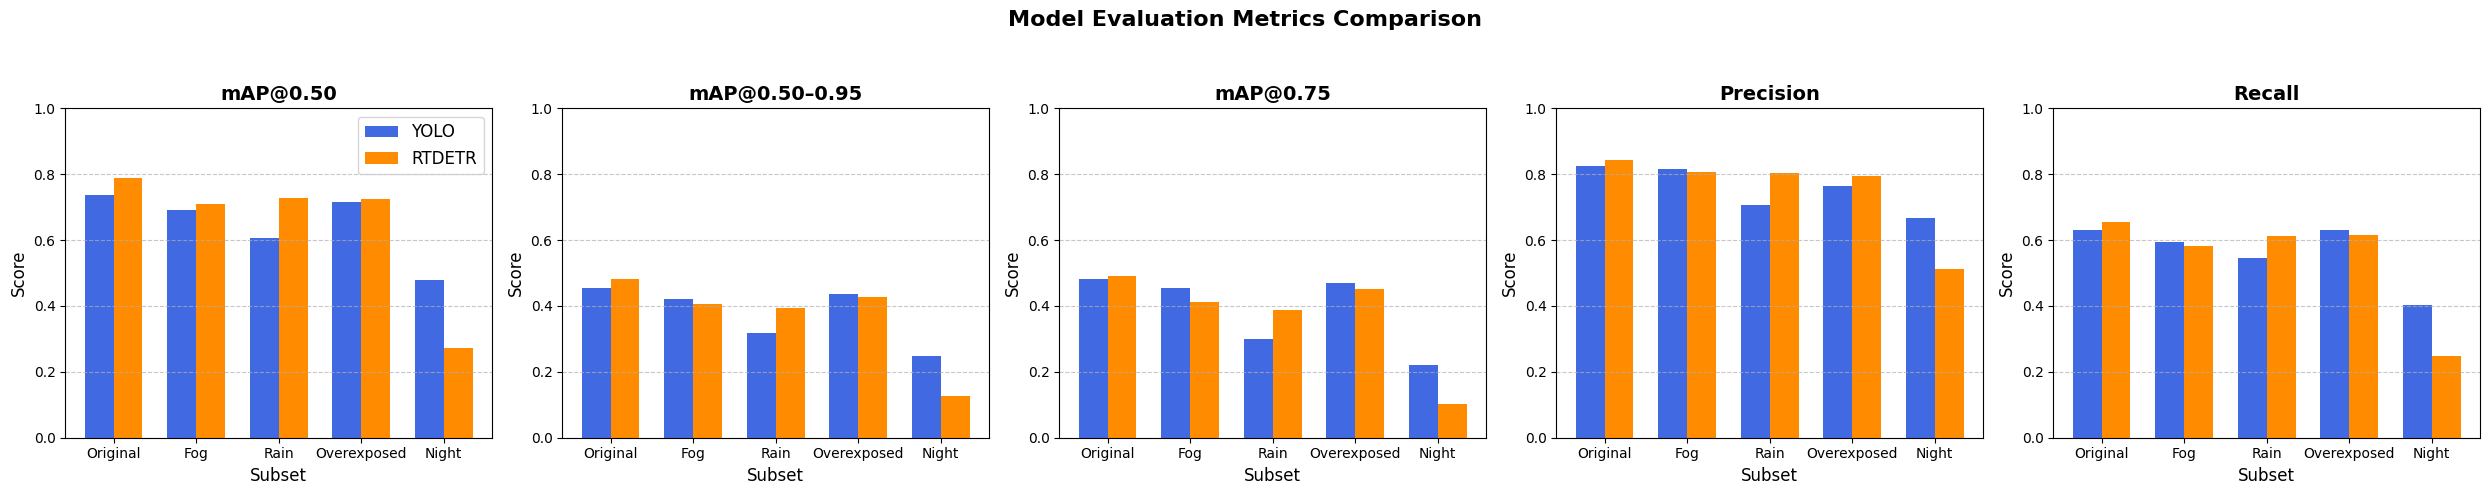

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Define the subsets
subsets = ["Original", "Fog", "Rain", "Overexposed", "Night"]

# YOLO metrics
yolo_map50      = [0.73765, 0.69013, 0.60632, 0.71457, 0.47754]
yolo_map50_95   = [0.45446, 0.42085, 0.31886, 0.43733, 0.24854]
yolo_map75      = [0.48260, 0.45373, 0.30010, 0.46909, 0.22012]
yolo_precision  = [0.82588, 0.81447, 0.70503, 0.76562, 0.66802]
yolo_recall     = [0.63131, 0.59545, 0.54417, 0.62927, 0.40280]

# RTDETR metrics
rtdetr_map50      = [0.78986, 0.70833, 0.72905, 0.72505, 0.27207]
rtdetr_map50_95   = [0.48050, 0.40544, 0.39314, 0.42732, 0.12640]
rtdetr_map75      = [0.49203, 0.41185, 0.38916, 0.45220, 0.10389]
rtdetr_precision  = [0.84262, 0.80654, 0.80342, 0.79425, 0.51173]
rtdetr_recall     = [0.65634, 0.58319, 0.61121, 0.61646, 0.24869]

# Organize metrics in lists for easier plotting
metrics_names = ["mAP@0.50", "mAP@0.50–0.95", "mAP@0.75", "Precision", "Recall"]
yolo_metrics  = [yolo_map50, yolo_map50_95, yolo_map75, yolo_precision, yolo_recall]
rtdetr_metrics = [rtdetr_map50, rtdetr_map50_95, rtdetr_map75, rtdetr_precision, rtdetr_recall]

# Create subplots in one row for a side-by-side comparison
n_metrics = len(metrics_names)
fig, axs = plt.subplots(1, n_metrics, figsize=(25, 5))
bar_width = 0.35
indices = np.arange(len(subsets))

# Define custom colors for a modern look
color_yolo = "royalblue"
color_rtdetr = "darkorange"

# Plot each metric in its own subplot
for i in range(n_metrics):
    ax = axs[i]
    ax.bar(indices - bar_width/2, yolo_metrics[i], bar_width, label="YOLO", color=color_yolo)
    ax.bar(indices + bar_width/2, rtdetr_metrics[i], bar_width, label="RTDETR", color=color_rtdetr)
    
    ax.set_title(metrics_names[i], fontsize=14, fontweight="bold")
    ax.set_xlabel("Subset", fontsize=12)
    ax.set_ylabel("Score", fontsize=12)
    ax.set_xticks(indices)
    ax.set_xticklabels(subsets, fontsize=10)
    ax.set_ylim(0, 1)
    ax.grid(axis="y", linestyle="--", alpha=0.7)
    
    # Only add legend once to avoid redundancy
    if i == 0:
        ax.legend(fontsize=12)

plt.suptitle("Model Evaluation Metrics Comparison", fontsize=16, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.93])

plt.savefig("metrics_robustness.png", dpi=300)
plt.show()
